In [1]:
from climlab.solar.insolation import daily_insolation
import matplotlib.pyplot as plt
import numpy as np

The fundamental equation governing our climate model is
$$c_p \frac{\partial T}{\partial t}(\varphi) = S(\varphi)\left[1 - \alpha(\varphi)\right] - \left(1 - \frac{\epsilon}{2}\right)\sigma T^4(\varphi) + D(\varphi)\frac{\partial^2 T}{\partial\varphi^2}(\varphi)$$
where $T$ is the surface temperature. Since the heat capacity $c_p$ will be multiplied by the time step $\mathrm{d}t$, which is a free parameter, we neglect $c_p$ in what follows.

## Parameters and Constants ##

In [58]:
n_lats = 100
beta = 0
dt = 1e-3
eps = 0.76
S_0 = 1362
D = 1e-1
sigma = 5.67e-8

Next, we create the latitude array and note the latitude step size.

In [39]:
phi = np.linspace(-np.pi / 2, np.pi / 2, n_lats)
dphi = phi[1] - phi[0]

We also create an array of latitudes in degrees, as a plotting convenience.

In [40]:
lat = phi * (180 / np.pi)

## Insolation and Albedo ##
We use Brian Rose's `climlab` code to calculate insolation, considering the annual mean.

In [59]:
S = np.mean(
    daily_insolation(
        lat, day=np.arange(1, 366),
        orb={
            'ecc' : 0.017236,
            'long_peri' : 281.37,
            'obliquity' : beta
        }
    ),
    axis=1
)

Let's plot the insolation and verify that we're getting something reasonable.

(-90.0, 90.0)

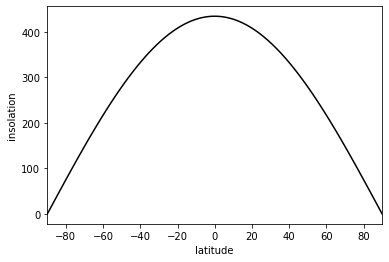

In [60]:
%matplotlib inline
_, ax = plt.subplots()
ax.plot(lat, S, color='k')

ax.set_xlabel('latitude')
ax.set_ylabel('insolation')
ax.set_xlim(-90, 90)

Next, we define an albedo function. For simplicity, we set
$$\alpha(\varphi) = \begin{cases}
0.3 & T(\varphi) > 273\textrm{ K} \\
0.6 & T(\varphi) \leq 273 \textrm{ K}
\end{cases}$$
In other words, when the temperature falls below freezing, the albedo jumps from $0.3$ to $0.6$.

In [49]:
def albedo(T):
    alpha = np.zeros(T.shape)
    alpha[T > 273] = 0.2
    alpha[T <= 273] = 0.6
    
    return alpha

## Estimating Derivatives in $\varphi$ ##

The last thing we need before we can begin seeking equilibria is some way to estimate $T_{\varphi\varphi}$. For latitudes in the interior of the domain, we can use a centered finite difference approximation:
$$\frac{\partial^2 T}{\partial\varphi^2}(\varphi) \approx \frac{T(\varphi + \mathrm{d}\varphi) - 2T(\varphi) + T(\varphi - \mathrm{d}\varphi)}{(\mathrm{d}\varphi)^2}$$
We use ghost points at the left and right edges so that $T_\varphi = 0$ at the poles.

In [23]:
def second_derivative(T, h):
    out = np.zeros(T.shape)
    
    out[0] = 2 * (T[1] - T[0])
    out[1:-1] = (T[:-2] - 2 * T[1:-1] + T[2:])
    out[-1] = 2 * (T[-2] - T[-1])
    
    return out / (h ** 2)

Let's test that our finite difference function works. We take the second derivative of $f(x) = \frac{x^3}{3} - x$, which should be $f''(x) = 2x$.

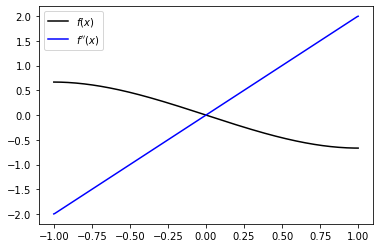

In [24]:
%matplotlib inline
_, ax = plt.subplots()

x = np.linspace(-1, 1, 300)
f = ((x ** 3) / 3) - x
d = second_derivative(f, x[1] - x[0])

ax.plot(x, f, color='k', label='$f(x)$')
ax.plot(x, d, color='b', label='$f\'\'(x)$')
ax.legend()

Note that this is a reasonable test function since we do indeed have $f'(x) = 0$ at the boundaries of the test domain $[-1, 1]$.

## Iterating Towards Equilibrium ##

Now we implement a loop to step the provided initial temperature towards equilibrium.

Converged after 5189 iterations.


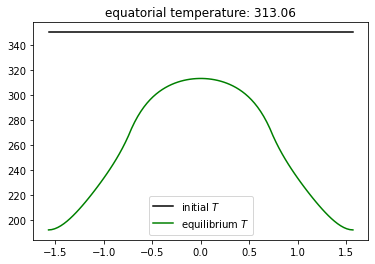

In [61]:
def equilibriate(T_0, max_iter=1e6, verbose=True):
    T = T_0
    dTdt = np.inf * np.ones(T.shape)
    
    n_iter = 0
    while abs(dTdt).max() > 1e-1 and n_iter < max_iter:
        dTdt = (
            S * (1 - albedo(T)) -
            (1 - 0.5 * eps) * sigma * (T ** 4) +
            D * second_derivative(T, dphi)
        )

        T = T + dTdt * dt
        n_iter = n_iter + 1
        
        if verbose and n_iter % int(max_iter / 10) == 0:
            print(f'Iteration {n_iter}: {abs(dTdt).max()}')
            
    if n_iter < max_iter:
        print(f'Converged after {n_iter} iterations.')
    else:
        print(f'Maximum iteration limit reached without convergence.')

    return T

T_0 = 350 * np.ones(phi.shape)
T = equilibriate(T_0)

%matplotlib inline
_, ax = plt.subplots()

ax.plot(phi, T_0, color='k', label='initial $T$')
ax.plot(phi, T, color='g', label=r'equilibrium $T$')

ax.set_title(f'equatorial temperature: {round(T[int(n_lats / 2)], 2)}')
ax.legend()

Now, let's investigate which equilibria we can reach. We'll start each simulation with an Earth at constant temperature across all latitudes, and see whether each starting temperature converges to the same temperature.

Converged after 4122 iterations.
Converged after 3815 iterations.
Converged after 4547 iterations.
Converged after 4652 iterations.
Converged after 4976 iterations.
Converged after 5109 iterations.


Text(0, 0.5, 'final equatorial temperature')

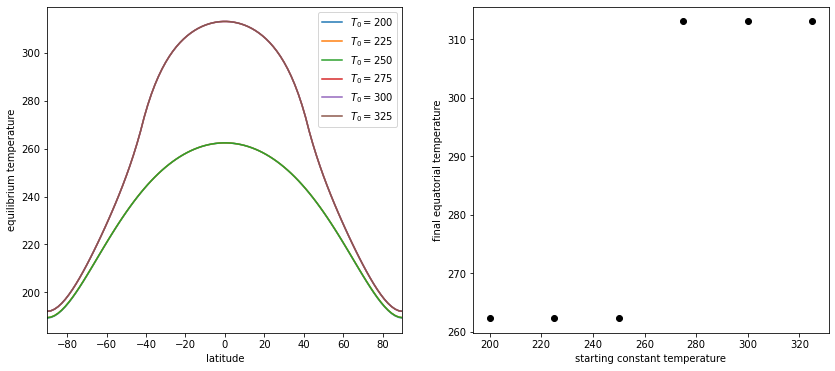

In [62]:
T_0s = 200 + 25 * np.arange(6)
eqs = np.zeros(T_0s.shape)

%matplotlib inline
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(14, 6)

for i, T_0 in enumerate(T_0s):
    T = equilibriate(T_0 * np.ones(phi.shape), verbose=False)
    eqs[i] = T[int(n_lats / 2)]
    
    ax1.plot(lat, T, label=f'$T_0 = {T_0}$')
    
ax1.set_xlabel('latitude')
ax1.set_ylabel('equilibrium temperature')
ax1.set_xlim(-90, 90)
ax1.legend()

ax2.scatter(T_0s, eqs, color='k')
ax2.set_xlabel('starting constant temperature')
ax2.set_ylabel('final equatorial temperature')